# Profiling for dates associated with Nome storms

This notebook is for analyzing the results from profiling the analog forecast method using dates where Nome, AK was hit by a storm (provided by collaborators). 


The dates provided will be referred to as the "dates of interest." We applied the skill profiling framework for the the third and fifth days preceding the dates of interest. 

In [36]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import numpy as np
# local
import luts
from config import data_dir
import analog_forecast as af
from run_naive_forecast import get_naive_sample_dates
from run_profile import forecast_and_error

Load and concatenate the results into single tables.

Analog and naive forecast results:

In [37]:
analog_df = pd.concat([
    pd.read_csv(fp) for fp in Path("results").glob("*.csv") 
    if (("naive" not in fp.name) and ("dates" not in fp.name))
])
naive_df = pd.concat([pd.read_csv(fp) for fp in Path("results").glob("*naive.csv")])

The top analogs were saved as separate tables, combine those as well:

In [38]:
analog_dates = pd.concat([pd.read_csv(fp) for fp in Path("results").glob("*dates.csv")])

## Create tables

Here we will create some useful tables from the CSVs containing results of the profiling.

First we'll just show some snapshots of the tables. Here is a case where the naive forecast is clearly better than the analog forecast using anomaly-based search, but where the standard search-based forecast is comparable.

Naive:

In [39]:
query_str = "forecast_domain == 'alaska' & variable == 't2m' & reference_date == '2011-11-06'"
naive_df.query(query_str).head()

,variable,forecast_domain,reference_date,forecast_day_number,naive_2.5,naive_50,naive_97.5
98,t2m,alaska,2011-11-06,1,2.934,4.066,6.874
99,t2m,alaska,2011-11-06,2,3.855,5.105,7.610
100,t2m,alaska,2011-11-06,3,3.939,5.151,7.489
101,t2m,alaska,2011-11-06,4,3.350,4.525,7.317
102,t2m,alaska,2011-11-06,5,3.358,4.340,7.248


Anomaly-based search:

In [40]:
analog_df.query(query_str + " & anomaly_search == True").head()

,variable,search_domain,forecast_domain,anomaly_search,reference_date,forecast_day_number,forecast_error
98,t2m,alaska,alaska,True,2011-11-06,1,8.605
99,t2m,alaska,alaska,True,2011-11-06,2,8.726
100,t2m,alaska,alaska,True,2011-11-06,3,8.201
101,t2m,alaska,alaska,True,2011-11-06,4,7.284
102,t2m,alaska,alaska,True,2011-11-06,5,7.307


Without the anomaly search, actually better for first couple of days:

In [41]:
analog_df.query(query_str + " & anomaly_search == False").head()

,variable,search_domain,forecast_domain,anomaly_search,reference_date,forecast_day_number,forecast_error
98,t2m,alaska,alaska,False,2011-11-06,1,2.954
99,t2m,alaska,alaska,False,2011-11-06,2,3.873
100,t2m,alaska,alaska,False,2011-11-06,3,5.382
101,t2m,alaska,alaska,False,2011-11-06,4,6.366
102,t2m,alaska,alaska,False,2011-11-06,5,6.700


### Saving tables

Now we will create and save some tables for collaborators to have a look at.

First, we are interested in looking at results for only a couple of key dates, and we want all of the forecast days available. We will do some things to make more user-friendly tables as well. 

Analog results:

In [44]:
# we want the reference dates that include these keep dates in the forecast
keep_dates = ["2004-10-11", "2011-11-09"]
analog_df["forecast_date"] = (pd.to_datetime(analog_df["reference_date"]) + pd.to_timedelta(analog_df["forecast_day_number"], unit="d"))
keep_ref_dates = analog_df.query("forecast_date in @keep_dates").reference_date
analog_df_subset = analog_df.query("reference_date in @keep_ref_dates").drop(columns="forecast_day_number")[
    # re-order columns
    ["variable", "search_domain", "forecast_domain", "anomaly_search", "reference_date", "forecast_date", "forecast_error"]
]
# main attributes to sort on
main_attrs = ["variable", "search_domain", "forecast_domain", "anomaly_search", "reference_date"]
analog_df_subset = analog_df_subset.sort_values(main_attrs)
analog_df_subset

,variable,search_domain,forecast_domain,anomaly_search,reference_date,forecast_date,forecast_error
112,msl,alaska,alaska,False,2004-10-06,2004-10-07,563.366
113,msl,alaska,alaska,False,2004-10-06,2004-10-08,1037.702
114,msl,alaska,alaska,False,2004-10-06,2004-10-09,1361.240
115,msl,alaska,alaska,False,2004-10-06,2004-10-10,1217.323
116,msl,alaska,alaska,False,2004-10-06,2004-10-11,1273.240
...,...,...,...,...,...,...,...
2347,z,panarctic,panarctic,True,2011-11-06,2011-11-16,1371.388
2348,z,panarctic,panarctic,True,2011-11-06,2011-11-17,1379.414
2349,z,panarctic,panarctic,True,2011-11-06,2011-11-18,1261.045
2350,z,panarctic,panarctic,True,2011-11-06,2011-11-19,1239.354


We will provide a table of the 5 analogs to go along with this. We want this to be sorted in the same manner for ease of use.

In [46]:
# top_dates = analog_dates.loc[analog_dates.groupby(main_attrs).analog_score.idxmin()]
top_dates_subset = analog_dates.query("reference_date in @keep_ref_dates").drop_duplicates().sort_values(main_attrs)
top_dates_subset

,variable,search_domain,forecast_domain,anomaly_search,reference_date,analog_date,analog_score
40,msl,alaska,alaska,False,2004-10-06,1995-10-09,418.226
41,msl,alaska,alaska,False,2004-10-06,1964-09-30,455.464
42,msl,alaska,alaska,False,2004-10-06,1983-11-04,473.088
43,msl,alaska,alaska,False,2004-10-06,2014-09-18,474.884
44,msl,alaska,alaska,False,2004-10-06,2005-10-12,477.964
...,...,...,...,...,...,...,...
835,z,panarctic,panarctic,True,2011-11-06,1999-11-07,1022.427
836,z,panarctic,panarctic,True,2011-11-06,1987-10-25,1092.262
837,z,panarctic,panarctic,True,2011-11-06,1979-11-17,1101.005
838,z,panarctic,panarctic,True,2011-11-06,2000-10-09,1107.934


Do the same thing as above with the naive forecast results to get a table for comparison:

In [48]:
naive_df["forecast_date"] = (pd.to_datetime(naive_df["reference_date"]) + pd.to_timedelta(naive_df["forecast_day_number"], unit="d"))
naive_df_subset = naive_df.query("reference_date in @keep_ref_dates.unique()").drop(columns="forecast_day_number")[
    # re-order columns
    ["variable", "forecast_domain", "reference_date", "forecast_date", "naive_2.5", "naive_50", "naive_97.5"]
# no anomaly_search option for naive forecasting
].sort_values(["variable", "forecast_domain", "reference_date"])
naive_df_subset

,variable,forecast_domain,reference_date,forecast_date,naive_2.5,naive_50,naive_97.5
112,msl,alaska,2004-10-06,2004-10-07,704.319,1012.977,1434.184
113,msl,alaska,2004-10-06,2004-10-08,1011.980,1338.204,1728.834
114,msl,alaska,2004-10-06,2004-10-09,995.761,1422.195,1917.000
115,msl,alaska,2004-10-06,2004-10-10,928.074,1308.083,1752.928
116,msl,alaska,2004-10-06,2004-10-11,935.454,1334.202,1756.820
...,...,...,...,...,...,...,...
555,z,panarctic,2011-11-06,2011-11-16,1022.687,1282.783,1570.686
556,z,panarctic,2011-11-06,2011-11-17,1085.104,1328.897,1608.356
557,z,panarctic,2011-11-06,2011-11-18,1083.037,1314.669,1591.053
558,z,panarctic,2011-11-06,2011-11-19,1080.078,1314.302,1610.698


Now save these tables. Going to include the date of creation here to help track the potentially many tables we could end up generating:

In [49]:
from datetime import datetime
Path("tables").mkdir(exist_ok=True)
today = datetime.today().strftime('%Y%m%d')
analog_df_subset.to_csv(f"tables/analog_profiling_results_{today}.csv", index=False)
top_dates_subset.to_csv(f"tables/profiling_top_analogs_{today}.csv", index=False)
naive_df_subset.to_csv(f"tables/naive_profiling_results_{today}.csv", index=False)

## Visualize results

Do some general charting of results. We don't have any specific requests here yet to support the research, so we will just create a few line charts to share.

### Error over time

Generate some line charts of error over time for a variety of combinations.

In [90]:
def plot_error_by_fday_line_chart(varname, search_domain, forecast_domain, ref_date):
    fig, ax = plt.subplots(1, 1, figsize=(7, 4))
    query_str = (
        "forecast_domain == @forecast_domain "
        "& search_domain == @search_domain "
        "& variable == @varname "
        "& reference_date == @ref_date"
    )
    
    naive_query_str = query_str.replace("& search_domain == @search_domain", " ")
    plot_df = naive_df.query(
        # only forecast_domain in naive_df
        naive_query_str
    )[["forecast_date", "naive_2.5", "naive_50", "naive_97.5"]].set_index("forecast_date")
    
    analog_query_str = query_str + " & anomaly_search == True"
    plot_df = plot_df.join(
        analog_df.query(analog_query_str)[[
            "forecast_date", "forecast_error"
        ]].set_index("forecast_date").rename(
            columns={"forecast_error": "anom_forecast_error"}
        )
    )
    
    anom_query_str = analog_query_str.replace("anomaly_search == True", "anomaly_search == False")
    plot_df = plot_df.join(
        analog_df.query(anom_query_str)[[
            "forecast_date", "forecast_error"
        ]].set_index("forecast_date").rename(
            columns={"forecast_error": "forecast_error"}
        )
    )
    plot_df.plot(title=f"{varname},  search={search_domain}, forecast={forecast_domain},  Reference Date: {ref_date}", ax=ax)
    ax.set_ylabel("RMSE")


Check out the different variables for 2011-11-06, where search and forecast domains are both Alaska:

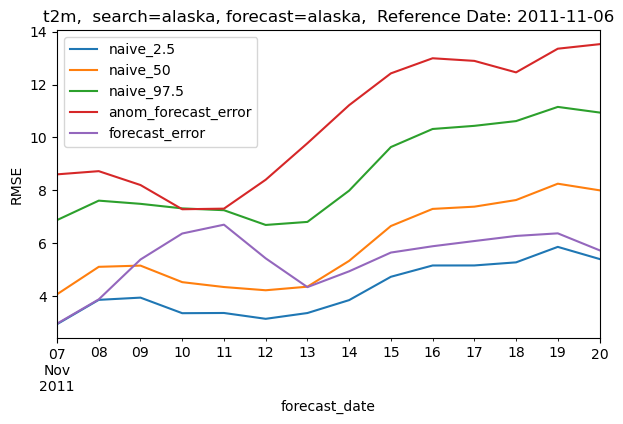

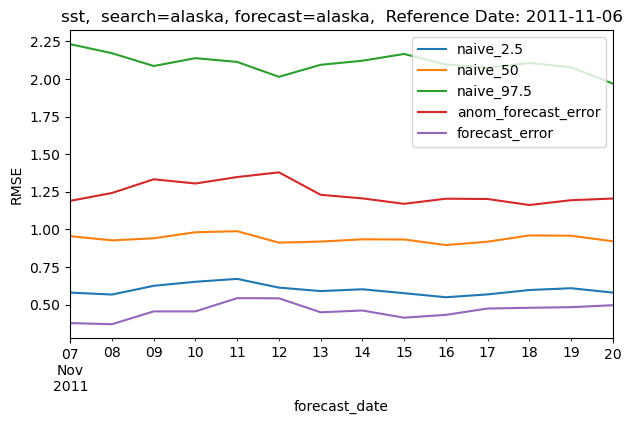

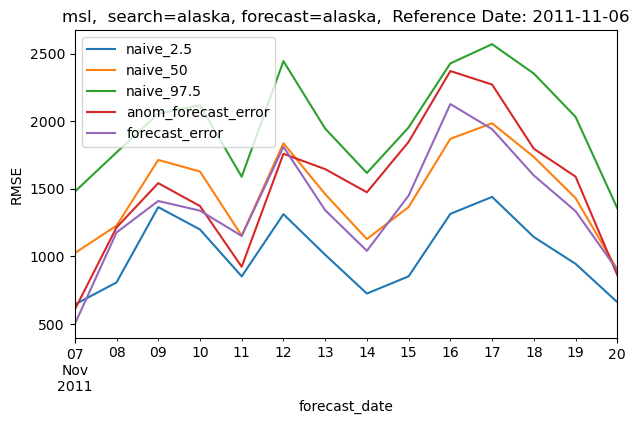

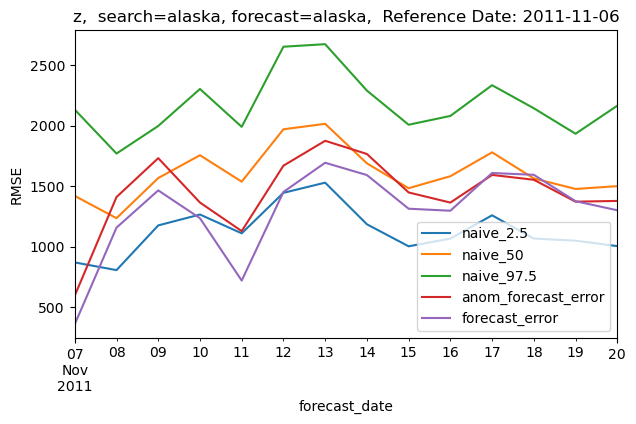

In [91]:
kwargs = dict(search_domain="alaska", forecast_domain="alaska", ref_date="2011-11-06")
plot_error_by_fday_line_chart("t2m", **kwargs)
plot_error_by_fday_line_chart("sst", **kwargs)
plot_error_by_fday_line_chart("msl", **kwargs)
plot_error_by_fday_line_chart("z", **kwargs)

Now let's examine air temperature forecasts for alaska, for the other possible search domains:

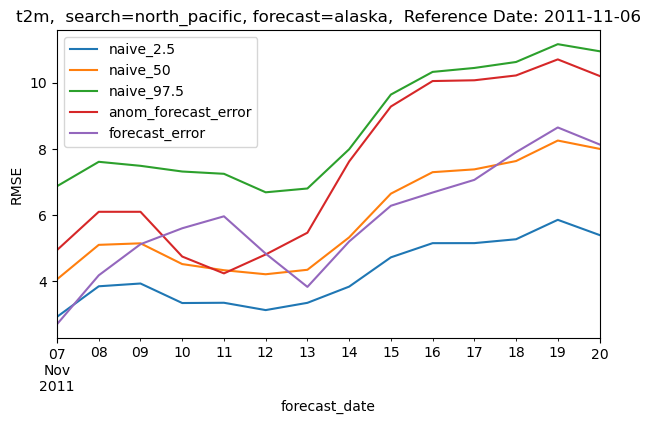

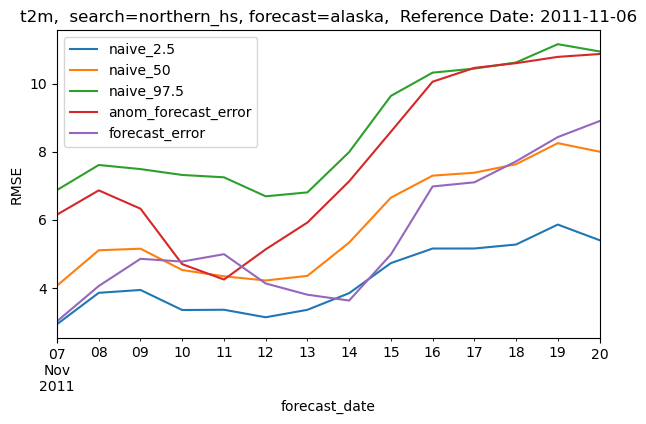

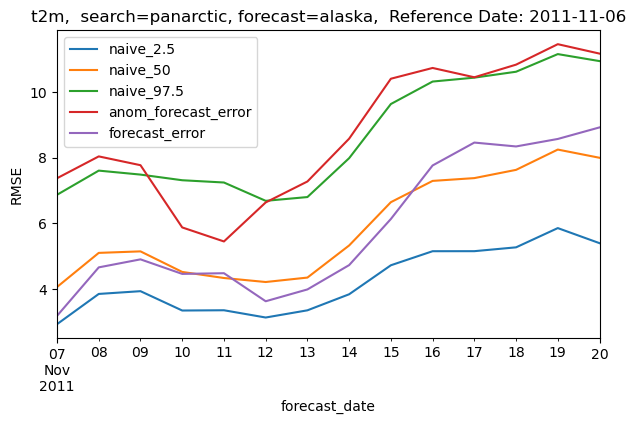

In [93]:
for search_domain in ["north_pacific", "northern_hs", "panarctic"]:
    kwargs.update(search_domain=search_domain)
    plot_error_by_fday_line_chart("t2m", **kwargs)

#### Poor performance of anomalies

In this section, we will drill down on the poor performance of anomaly-based search. In particular, here is an example where anomaly-based search seems to perform worse than the naive forecast most of the time:

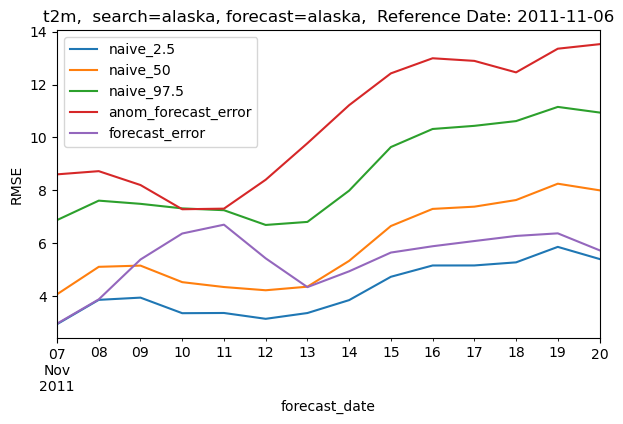

In [104]:
kwargs = dict(search_domain="alaska", forecast_domain="alaska", ref_date="2011-11-06")
plot_error_by_fday_line_chart("t2m", **kwargs)

Check out the analog dates for both anomaly and normal search:

In [102]:
search_domain="alaska"
forecast_domain="alaska"
ref_date="2011-11-06"

analog_dates.query((
    "variable == @varname & search_domain == @search_domain & "
    "forecast_domain == @forecast_domain & reference_date == @ref_date & anomaly_search == True"
))

,variable,search_domain,forecast_domain,anomaly_search,reference_date,analog_date,analog_score
35,t2m,alaska,alaska,True,2011-11-06,1971-10-01,2.720
36,t2m,alaska,alaska,True,2011-11-06,2009-09-30,2.857
37,t2m,alaska,alaska,True,2011-11-06,1986-09-27,2.884
38,t2m,alaska,alaska,True,2011-11-06,2013-09-25,2.925
39,t2m,alaska,alaska,True,2011-11-06,1959-09-24,2.951


In [103]:
analog_dates.query((
    "variable == @varname & search_domain == @search_domain & "
    "forecast_domain == @forecast_domain & reference_date == @ref_date & anomaly_search == False"
))

,variable,search_domain,forecast_domain,anomaly_search,reference_date,analog_date,analog_score
35,t2m,alaska,alaska,False,2011-11-06,2004-11-03,3.279
36,t2m,alaska,alaska,False,2011-11-06,1964-11-08,3.290
37,t2m,alaska,alaska,False,2011-11-06,2010-11-27,3.344
38,t2m,alaska,alaska,False,2011-11-06,1999-11-18,3.394
39,t2m,alaska,alaska,False,2011-11-06,2012-11-15,3.399


Plot some other reference dates for this same trial config:

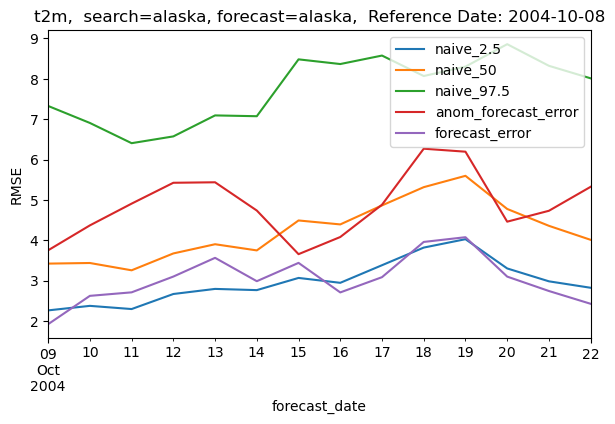

In [110]:
kwargs = dict(search_domain="alaska", forecast_domain="alaska", ref_date="2004-10-08")
plot_error_by_fday_line_chart("t2m", **kwargs)

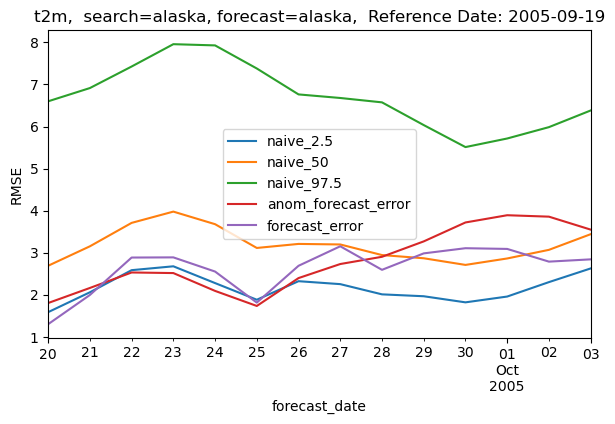

In [111]:
kwargs = dict(search_domain="alaska", forecast_domain="alaska", ref_date="2005-09-19")
plot_error_by_fday_line_chart("t2m", **kwargs)

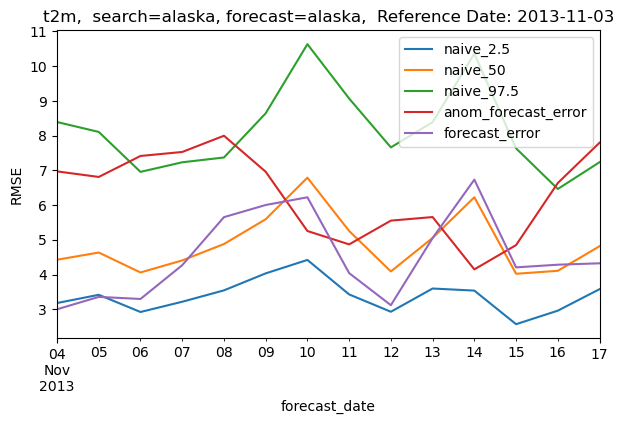

In [112]:
kwargs = dict(search_domain="alaska", forecast_domain="alaska", ref_date="2013-11-03")
plot_error_by_fday_line_chart("t2m", **kwargs)